# 04 &mdash; Correlation Analysis

*(Data Analysis and Visualization 505067 &mdash; Final Report)*

**Authored by:** Nguyen Phuc Toan

## Prerequisites

### Importing libraries

In [1]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

### Loading data

In [2]:
df = pd.read_csv("../data/salaries.csv")

### Preprocessing

**Explanation:**

1. Drop duplicates with `df.drop_duplicates()`.
2. Log-transform salary to improve normality.
3. Remove outliers with MAD.

In [3]:
df = df.drop_duplicates()
df.shape

(27311, 11)

In [4]:
target_col = "salary_in_usd"

df[target_col] = np.log1p(df[target_col])

In [5]:
target_col = "salary_in_usd"

median = df[target_col].median()
mad = np.median(np.abs(df[target_col] - median))
mod_z = 0.6745 * (df[target_col] - median) / mad

df = df[np.abs(mod_z) < 3.5]
df.shape

(27220, 11)

### Ordinal encoding

**Explanation:**

Encode ordinal categorical variables as numeric ranks to preserve order and prepare for correlation analysis.

In [6]:
ordinal_encodes = {
    "experience_level": {"EN": 1,"MI": 2,"SE": 3,"EX": 4},
    "company_size": {"S": 1, "M": 2, "L": 3},
}

for col, encodes in ordinal_encodes.items():
    df[f"_{col}"] = df[col].map(encodes)

df[["experience_level", "_experience_level", "company_size", "_company_size"]].tail()

,experience_level,_experience_level,company_size,_company_size
57189,SE,3,L,3
57190,MI,2,L,3
57191,EN,1,S,1
57192,EN,1,L,3
57193,SE,3,L,3


## Spearman rank correlation coefficient

Spearman's rank correlation coefficient $\rho$ measures monotonic relationships without assuming linearity; good for ordinal or non-normally distributed variables.

* **Features**: work year, remote ratio, experience level, company size
* **Target**: salary (USD)

In [7]:
feature_cols = ["work_year", "remote_ratio", "_experience_level", "_company_size"]
target_col = "salary_in_usd"

In [8]:
for col in feature_cols:
    rho, p_value = stats.spearmanr(df[target_col], df[col])
    print(f"[{col}] Spearman rho = {rho}; p-value = {p_value}")

[work_year] Spearman rho = 0.049996593119945254; p-value = 1.538695350683143e-16
[remote_ratio] Spearman rho = -0.034479090858291726; p-value = 1.2707063690329234e-08
[_experience_level] Spearman rho = 0.354728047363505; p-value = 0.0
[_company_size] Spearman rho = -0.014309101645989976; p-value = 0.018235690366930526


**Summary:**

$\text{p–values} < 0.05$ indicate statistically significant monotonic relationships.

## Plots

### Spearman correlation matrix

**Explanation:**

Visualize correlations between features and target in a heatmap.

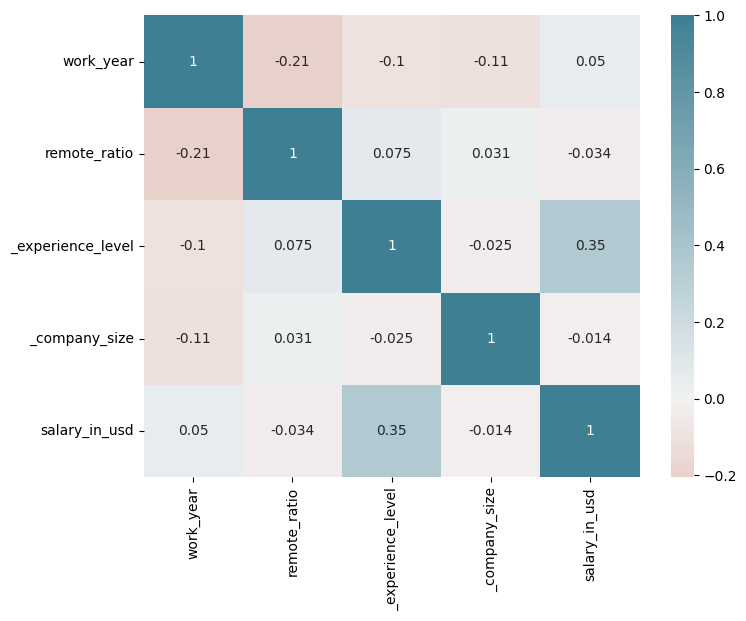

In [9]:
corr_matrix = df[feature_cols + [target_col]].corr(method="spearman")

plt.figure(figsize=(8, 6))

palette = sns.diverging_palette(20, 220, as_cmap=True)
sns.heatmap(corr_matrix, annot=True, cmap=palette, center=0)

plt.show()

**Summary:**

* Experience level has the highest positive $\rho$
* Remote ratio has the highest negative $\rho$ with work year $\Rightarrow$ Supports our question on compensation on remote work.

### Boxplots + regression lines

**Explanation:**

Boxplots with median-based regression lines show feature-target relationships and monotonicity visually.

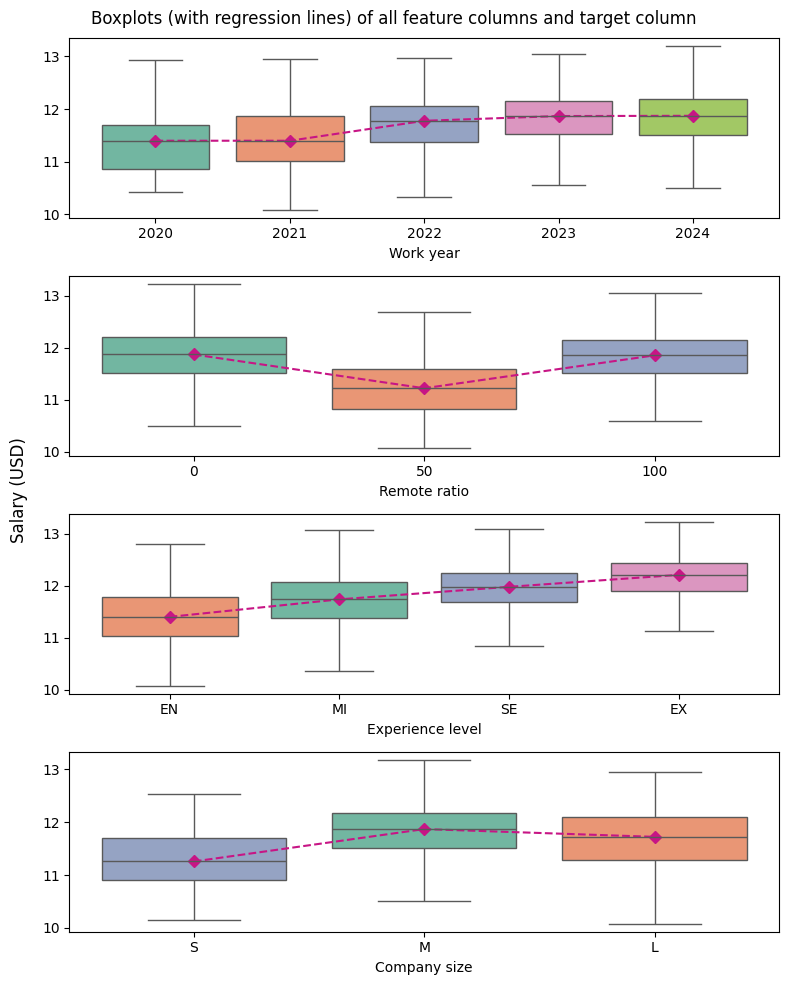

In [10]:
fig, axes = plt.subplots(len(feature_cols), 1, figsize=(8, 10))

for i, col in enumerate(feature_cols):
    actual_col = re.sub(r"^_", "", col)
    
    order = None
    medians = df.groupby(actual_col)[target_col].median()
    
    if actual_col != col:
        order = df.groupby(actual_col)[col].median().sort_values().index
        medians = medians.loc[order]
    
    sns.boxplot(
        data=df, x=actual_col, y=target_col, order=order,
        hue=actual_col, palette="Set2", ax=axes[i],
        legend=False, showfliers=False,
    )
    axes[i].plot(
        range(len(medians)), medians.values,
        color="mediumvioletred", marker="D", linestyle="--",
    )

    axes[i].set_xlabel(actual_col.replace("_", " ").capitalize())
    axes[i].set_ylabel("")

fig.suptitle("Boxplots (with regression lines) of all feature columns and target column")
fig.supylabel("Salary (USD)")

plt.tight_layout()

plt.show()

**Summary:**

* Experience level has a roughly linear upward trend (highest positive $\rho$).
* Remote ratio and company size have a unique V-shape regression lines ($\rho \approx 0$).
* Work year shows slight, inconsistent upward trend.

## Conclusion

* All numeric and ordinal categorical features show meaningful relationships with salary.
* Experience level has a monotonic correlation with salary; others show little to no monotonicities.